In [1]:
import os
import tarfile
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow_probability as tfp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

tf.random.set_seed(1234)

In [2]:
pip install smilite

In [3]:
import smilite

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path='/content/drive/MyDrive/sub.csv'

In [6]:
df = pd.read_csv(path)

In [7]:
#considering only 36000 molecules of data
df=df.iloc[:36000,:]

In [8]:
df.head()

,zinc_id,smiles
0,ZINC000000000007,C=CCc1ccc(OCC(=O)N(CC)CC)c(OC)c1
1,ZINC000000000010,C[C@@]1(c2ccccc2)OC(C(=O)O)=CC1=O
2,ZINC000000000011,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1N(C)C
3,ZINC000000000012,O=C(C[S@@](=O)C(c1ccccc1)c1ccccc1)NO
4,ZINC000000000014,CC[C@H]1[C@H](O)N2[C@H]3C[C@@]45c6ccccc6N(C)[C...


In [9]:
df.shape

(36000, 2)

In [10]:
df1=df['smiles']

In [11]:
smile_list=list()
for i in range(df1.shape[0]):
  smile_list.append(smilite.simplify_smile(df1[i]))



In [12]:
print(smile_list)

['C=CCC1CCC(OCC(=O)N(CC)CC)C(OC)C1', 'CC1(C2CCCCC2)OC(C(=O)O)=CC1=O', 'COC1CC(CC2CNC(N)NC2N)CC(OC)C1N(C)C', 'O=C(CS(=O)C(C1CCCCC1)C1CCCCC1)NO', 'CCC1C(O)N2C3CC45C6CCCCC6N(C)C4C2CC1C3C5O', 'CC(C(=O)O)N(CCCL)CCCL', 'CC1(C)OC2CC3C4CC(F)C5=CC(=O)C=CC5(C)C4(F)C(O)CC3(C)C2(C(=O)CO)O1', 'CCCS(=O)C1CCC2N/C(=N\\C(=O)OC)NC2C1', 'C=CCN1C(=O)C(CC(C)C)NC1=S', 'C=CCC1CN(C)CCC1(OC(=O)CC)C1CCCCC1', 'C=C(C)CNC1CCC(C(C)C(=O)O)CC1', 'C=CCC1CCCCC1OCC(O)CNC(C)C', 'OC1C=C2CCN3CC4CC5C(CC4C(C1O)C23)OCO5', 'CC1(C)OC2CC3C4CC(F)C5=CC(=O)C=CC5(C)C4(F)C(O)CC3(C)C2(C(=O)CO)O1', 'CC1(C)OC2CC3C4CC(F)C5=CC(=O)C=CC5(C)C4(F)C(O)CC3(C)C2(C(=O)CO)O1', 'NC(CCC1CCC(N(CCCL)CCCL)CC1)C(=O)O', 'NC1CCC2C(C1)C(=O)NC(CCCL)O2', 'CC(CC(C(N)=O)(C1CCCCC1)C1CCCCC1)N(C)C', 'CC1C(NC(=O)C(C)N(C)C)C(=O)N(C2CCCCC2)N1C', 'CCC(C)NCC(O)C1CCC(N)CC1', 'CC(C)CCOC(CN1CCCC1)C1CCCCC1', 'O=C(O)C(O)C1CCCCC1', 'CCC(C)(CN(C)C)OC(=O)C1CCCCC1', 'CC(C)(C)NCC(O)COC1CCCCC1NC(=O)C1CCCO1', 'CC12CC3CONC3CC1CCC1C2CCC2(C)C1CCC2(C)O', 'COC1CCC2C(C1)CC(C)N(CCC1CCC(

In [13]:
df['simple_smiles']=smile_list

In [14]:
df.head()

,zinc_id,smiles,simple_smiles
0,ZINC000000000007,C=CCc1ccc(OCC(=O)N(CC)CC)c(OC)c1,C=CCC1CCC(OCC(=O)N(CC)CC)C(OC)C1
1,ZINC000000000010,C[C@@]1(c2ccccc2)OC(C(=O)O)=CC1=O,CC1(C2CCCCC2)OC(C(=O)O)=CC1=O
2,ZINC000000000011,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1N(C)C,COC1CC(CC2CNC(N)NC2N)CC(OC)C1N(C)C
3,ZINC000000000012,O=C(C[S@@](=O)C(c1ccccc1)c1ccccc1)NO,O=C(CS(=O)C(C1CCCCC1)C1CCCCC1)NO
4,ZINC000000000014,CC[C@H]1[C@H](O)N2[C@H]3C[C@@]45c6ccccc6N(C)[C...,CCC1C(O)N2C3CC45C6CCCCC6N(C)C4C2CC1C3C5O


### **Train and validation split**

In [15]:
# split the data into train and validation set
x_train, x_val = train_test_split(df['simple_smiles'], test_size = 0.1, random_state = 42)

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')

Shape of x_train: (32400,)
Shape of x_val: (3600,)


### **Dictionary of unique characters**

In [18]:
# Unique character set with start and end tokens
char_set = set(''.join(list(df.simple_smiles)) + '!E')

# character to int mapping
char_to_int = dict((c, i) for i, c in enumerate(char_set))

# int to character mapping
int_to_char = dict((i, c) for i, c in enumerate(char_set))
# maximum length of sequence
max_len = max([len(smile) for smile in df.simple_smiles]) +2
print(char_set)
print(f'Character to integer dictionary: \n {char_to_int}')
print('\n')
print(f'Integer to character dictionary: \n {int_to_char}')



{'7', '4', '\\', 'L', 'N', ')', 'B', '6', 'E', 'C', '!', '5', '2', 'R', '(', 'P', 'S', '3', '/', '1', 'I', '=', 'F', 'O'}
Character to integer dictionary: 
 {'7': 0, '4': 1, '\\': 2, 'L': 3, 'N': 4, ')': 5, 'B': 6, '6': 7, 'E': 8, 'C': 9, '!': 10, '5': 11, '2': 12, 'R': 13, '(': 14, 'P': 15, 'S': 16, '3': 17, '/': 18, '1': 19, 'I': 20, '=': 21, 'F': 22, 'O': 23}


Integer to character dictionary: 
 {0: '7', 1: '4', 2: '\\', 3: 'L', 4: 'N', 5: ')', 6: 'B', 7: '6', 8: 'E', 9: 'C', 10: '!', 11: '5', 12: '2', 13: 'R', 14: '(', 15: 'P', 16: 'S', 17: '3', 18: '/', 19: '1', 20: 'I', 21: '=', 22: 'F', 23: 'O'}


In [17]:
print(f'Character set: {str(char_set)}')
print(f'Number of characters: {len(char_set)}\t Maximum Length of molecule in SMILES: {max_len}')

Character set: {'7', '4', '\\', 'L', 'N', ')', 'B', '6', 'E', 'C', '!', '5', '2', 'R', '(', 'P', 'S', '3', '/', '1', 'I', '=', 'F', 'O'}
Number of characters: 24	 Maximum Length of molecule in SMILES: 66


### **One hot encoding**

In [19]:
def smile_to_one_hot(smile,max_len):
  one_hot=np.zeros( ( max_len, len( char_set ) ) )     
  
  # encode the start token
  one_hot[0, char_to_int["!"]] = 1
  # encode the characters of smile string
  for row, char in enumerate(smile):
        one_hot[row+1, char_to_int[char]] = 1
  # encode the end token
  one_hot[len(smile) + 1:, char_to_int['E']] = 1
  return one_hot





In [20]:
def multiple_smile_to_one_hot(smile_list,max_len):
  
  one_hot_encoded_data= np.array([smile_to_one_hot(x,max_len+2) for x in smile_list])
  return one_hot_encoded_data


In [21]:

one_hot_encoded_data=multiple_smile_to_one_hot(df.simple_smiles,max_len)

In [22]:
one_hot_encoded_data.shape

(36000, 68, 24)

### **Visualizing one hot encoded text**

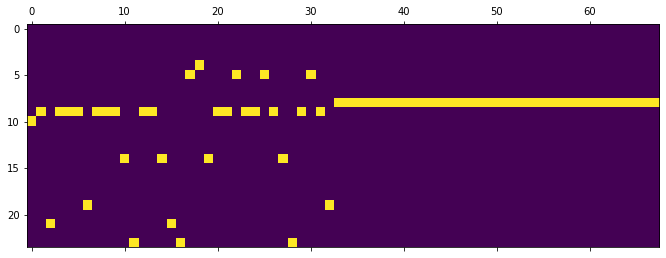

In [23]:
# show the one hot encoded version of the string
plt.matshow(one_hot_encoded_data[0].T)

### **Decoding the data from one hot encoding**

In [24]:
def char_decoder( X ):
    X = X.argmax( axis=-1 )
    decoded_char = ''
    for i in X:
      encoded_char=int_to_char[ i ]
      if encoded_char!='E' :
         decoded_char += encoded_char
      
    return decoded_char[1:]

### **Adding a dimension to the encoded molecule**

In [25]:
# adding a dimension
one_hot_encoded_data = one_hot_encoded_data.reshape(one_hot_encoded_data.shape[0],one_hot_encoded_data.shape[1],one_hot_encoded_data.shape[2],1)


In [26]:
one_hot_encoded_data.shape

(36000, 68, 24, 1)

In [27]:
# split the data into train and validation set
x_train, x_val = train_test_split(one_hot_encoded_data, test_size = 0.1, random_state = 42)

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')

Shape of x_train: (32400, 68, 24, 1)
Shape of x_val: (3600, 68, 24, 1)


In [28]:
# preparing data for training
#batch size is 32
train_dataset = (tf.data.Dataset.from_tensor_slices(one_hot_encoded_data).batch(32))

In [ ]:
#define VAE as a class
class VAE(tf.keras.Model):


  def __init__(self, latent_dim):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    # defining encoder
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(68, 24, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )
    # defining decoder
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=17*6*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(17, 6, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(68, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [ ]:
# Define loss fn and training step
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  x_logit = tf.cast(x_logit, tf.float64)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  logpz = tf.cast(logpz, tf.float64)
  logqz_x = tf.cast(logqz_x, tf.float64)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
latent_dim=2
# train steps
model = VAE(latent_dim)
epochs = 100

loss=0
for epoch in range(1, epochs + 1):
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
    loss+=compute_loss(model,train_x )
  print("epoch:", epoch, " of ", epochs)

 

VAE started!!
epoch: 1  of  100  total epochs  with loss tf.Tensor(297278.59379341296, shape=(), dtype=float64)
epoch: 2  of  100  total epochs  with loss tf.Tensor(425293.60139278584, shape=(), dtype=float64)
epoch: 3  of  100  total epochs  with loss tf.Tensor(538178.612768663, shape=(), dtype=float64)
epoch: 4  of  100  total epochs  with loss tf.Tensor(646030.6556858994, shape=(), dtype=float64)
epoch: 5  of  100  total epochs  with loss tf.Tensor(752039.4355803739, shape=(), dtype=float64)
epoch: 6  of  100  total epochs  with loss tf.Tensor(856463.118466488, shape=(), dtype=float64)
epoch: 7  of  100  total epochs  with loss tf.Tensor(959843.4187391222, shape=(), dtype=float64)
epoch: 8  of  100  total epochs  with loss tf.Tensor(1062661.9740285587, shape=(), dtype=float64)
epoch: 9  of  100  total epochs  with loss tf.Tensor(1165127.608932721, shape=(), dtype=float64)
epoch: 10  of  100  total epochs  with loss tf.Tensor(1267331.0280310286, shape=(), dtype=float64)
epoch: 11  of

KeyboardInterrupt: ignored

In [ ]:
# makes molecules decoded from the latent space.
def latent_space_mat(model, lat_vars):
  
  
  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, 10))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, 10))
#  specifying width and height of matrix
  image = np.zeros((24, 68))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      a = lat_vars[0] if lat_vars[0] != 0 else xi
      b = lat_vars[1] if lat_vars[1] != 0 else yi
      c = np.array([[a, b]]) 
      decoded = model.sample(c)
      drug = tf.reshape(decoded[0], (68, 24))
      return drug

#convert latent space variable to one hot encoded
def convert_latent(vec_float):
  max_arg = np.argmax(vec_float)
  mol_vec = [1 if j==max_arg else 0 for j,_ in enumerate(vec_float)]
  return mol_vec

In [ ]:
# Convert and print new molecules in simple smile format 
lspace=[1,3,4,6,8,9,16,25]
for i in range (0,8):
  mol = latent_space_mat(model,lat_vars = [lspace[i],0])
  mol_decode = [convert_latent(i) for i in mol]
  new_drug=char_decoder(np.array(mol_decode))
  new_drug=smilite.simplify_smile(new_drug)
  print("Drug ",i+1 ," :  ",new_drug)






Drug  1  :   CCC1CCC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC1
Drug  2  :   COC1CCC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC1
Drug  3  :   COC1CCC(C2CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
Drug  4  :   COC1CCC(C2CCCCCCCCCCCCCCC(=CCCCCCCCCCCCCCCC
Drug  5  :   COC1CCC(C2=CCCCCCCCCCCCCC====CCCCCCCCCCCCCC
Drug  6  :   COC1CCC(C2=CCCCCCCCCCCCCC====CCCCCCCCCCCCCC
Drug  7  :   CC1CCC(C22CCCCCCCCCCCCC=====CCCCCCCCCCCCC
Drug  8  :   CC1CCC(C22CCCCCCCCCCCCC=====CCCCCCCCCCCC
